# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow
tensorflow.__version__

#### Change current working directory to project folder (1 mark)

In [5]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
os.chdir('F:/Face Recognition') # Set the working directory

### Extract the zip file (5 Marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [49]:
pinterest_images = 'Aligned Face Dataset from Pinterest.zip'
import zipfile
archive = zipfile.ZipFile(pinterest_images, 'r')
archive.extractall()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\GreatLakes\\Face Recognition\\PINS\\pins_Natalie Portman \\Natalie Portman 0.jpg'

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [9]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

### Define function to load image
- Define a function to load image from the metadata

In [10]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (5 Marks)
- Load one image using the function "load_image"

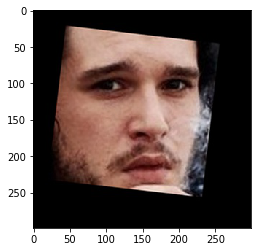

In [12]:
import matplotlib.pyplot as plt
plt.imshow(load_image(metadata[np.random.randint(0, 10770)].image_path()))

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (5 Marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [14]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
____

### Get vgg_face_descriptor

In [15]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [16]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (5 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [19]:
# Method to generate embeddings for all images
def generate_all_embeddings(metadata):
    # Create an embedding vector of all zeros, then fill it up with actual image embeddings iteratively.
    embeddings = np.zeros((metadata.shape[0], 2622))
    for idx, meta in enumerate(metadata):
        try:
            img = load_image(meta.image_path())
        # scale RGB values to interval [0,1]
            img = cv2.resize(img, dsize = (224,224))
            img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
            embeddings[idx] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        except Exception as ex:
            print('Could not generate embedding s for', meta.image_path(), ' Exception--', str(ex))
    return embeddings

In [20]:
import pickle
embedding_pkl = 'embeddings.pickle'

# Generate all embeddings and serialize it in the drive
if os.path.isfile(embedding_pkl) and os.path.getsize(embedding_pkl) > 0:
    embeddings = pickle.load(open(embedding_pkl,"rb"))
else:
    embeddings = generate_all_embeddings(metadata)
    with open(embedding_pkl, 'wb') as handle:
        pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [21]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

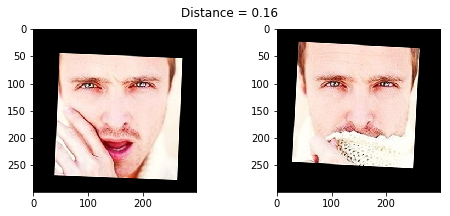

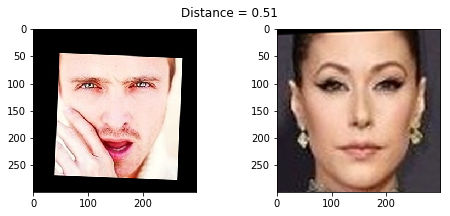

In [22]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

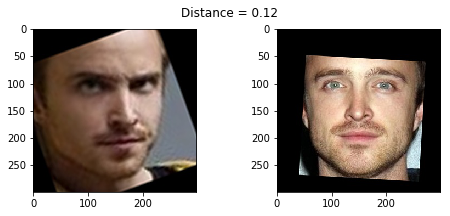

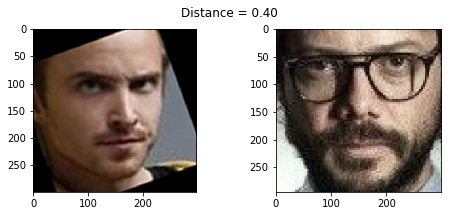

In [23]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(30, 31)
show_pair(30, 100)

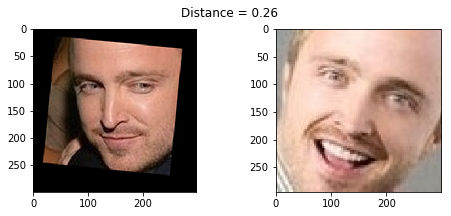

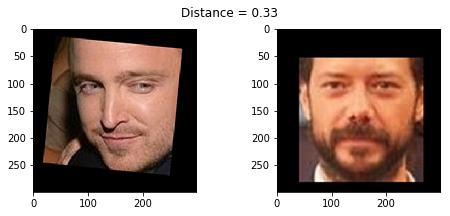

In [24]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets (5 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [25]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

### Encode the Labels (5 marks)
- Encode the targets
- Use LabelEncoder

In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Numerical encoding of identities
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Standardize the feature values (5 marks)
- Scale the features using StandardScaler

In [27]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Reduce dimensions using PCA (5 Marks)
- Reduce feature dimensions using Principal Component Analysis

In [28]:
from sklearn.decomposition import PCA
# Create a covariance matrix and calculate eigen values
covar_mat = PCA().fit(X_train)
# calculate variance ratios
var = covar_mat.explained_variance_ratio_;var

array([1.22710817e-01, 6.11775461e-02, 4.73503776e-02, ...,
       4.83829660e-10, 4.47806448e-10, 3.08236085e-11])

In [29]:
# cumulative sum of variance explained with [n] features
eigen_vals = np.round(covar_mat.explained_variance_ratio_, decimals=3)*100
np.cumsum(eigen_vals)

array([12.3, 18.4, 23.1, ..., 92.4, 92.4, 92.4])

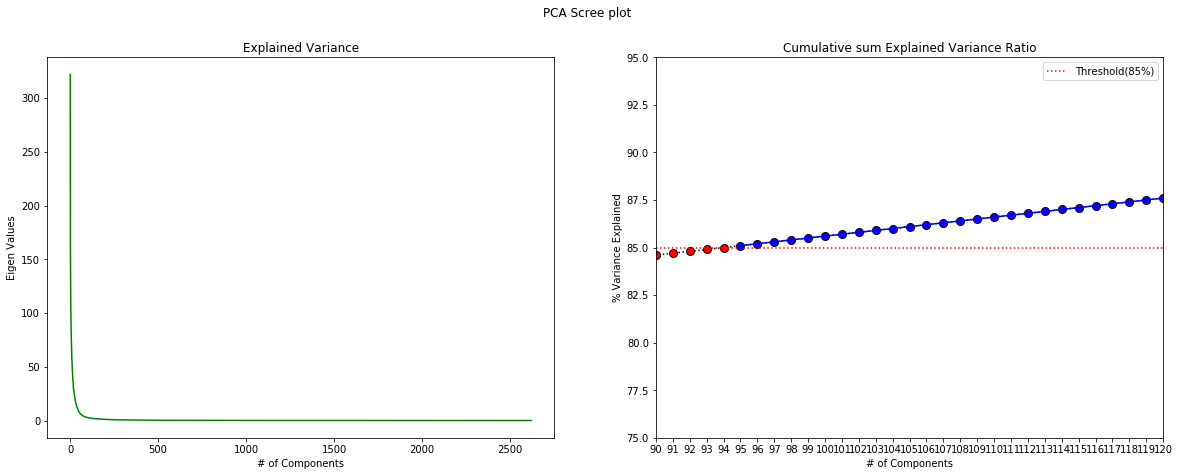

In [54]:
threshold=85
def generate_scree_plot(covar_matrix, threshold):
    var = covar_matrix.explained_variance_
    eigen_vals = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    f.suptitle('PCA Scree plot')
    ax1.plot(np.arange(1, len(var)+1), var, '-g')
    ax1.set_title('Explained Variance')
    ax1.set_xlabel('# of Components')
    ax1.set_ylabel('Eigen Values')

    ax2.plot(np.arange(1, len(eigen_vals)+1), eigen_vals, ':k', marker='o', markerfacecolor='red', markersize=8)
    ax2.set_xticks(np.arange(1, len(eigen_vals)+1))
    ax2.axhline(y=threshold, color='r', linestyle=':', label='Threshold(85%)')
    ax2.legend()
    ax2.plot(np.arange(sum(eigen_vals <= threshold) + 1, len(eigen_vals) + 1), 
             [val for val in eigen_vals if val > threshold], '-bo')
    ax2.set_ylim(bottom=threshold-10, top=95)
    ax2.set_xlim([90,120])
    ax2.set_title('Cumulative sum Explained Variance Ratio')
    ax2.set_xlabel('# of Components')
    ax2.set_ylabel('% Variance Explained')


generate_scree_plot(covar_mat, threshold=threshold)

94 components explaining more than 85% of variance. Hence considering n_component as 94 for PCA

In [55]:
pca = PCA(n_components=94, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Build a Classifier (3 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [56]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
print('Score of the classifier: %.2f%%' % (clf.score(X_test, y_test) * 100))

Score of the classifier: 97.13%


### Test results (2 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

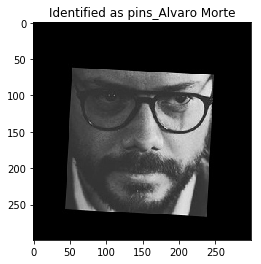

In [57]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = clf.predict([X_test[example_idx]])
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');